# 1) Install the required modules

# 2) Import the required modules

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from dateutil.relativedelta import relativedelta
import riskfolio as pf
import riskfolio.PlotFunctions as plf

#import vectorbt as vbt
from datetime import date

#import warnings
#warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math

import pyfolio as pyf

import itertools

from tqdm import tqdm

# 3) Price data from yahoo

## Mkts List

In [ ]:
# Tickers of assets
assets = ['TATAMOTORS.NS', 'RELIANCE.NS', 'INFY.NS', 'HDFC.NS', 'WIPRO.NS', 'ADANIPORTS.NS','SPARC.NS']
assets.sort()

## Stock prices and Daily returns

In [ ]:
# Downloading data
prices = yf.download(assets)['Adj Close']

# Calculating returns
dailyrets = prices.pct_change().dropna()
dailyrets.tail()

[*********************100%***********************]  7 of 7 completed


,ADANIPORTS.NS,HDFC.NS,INFY.NS,RELIANCE.NS,SPARC.NS,TATAMOTORS.NS,WIPRO.NS
Date,,,,,,,
2022-02-07,-0.016232,-0.030001,-0.014991,-0.006091,-0.027326,-0.011986,-0.025798
2022-02-08,0.003705,-0.005580,0.001341,0.016810,-0.010900,-0.003740,0.005835
2022-02-09,0.021803,0.008594,0.011646,0.011651,0.006829,0.017250,0.015529
2022-02-10,-0.003272,0.016917,0.018592,-0.001028,0.000462,0.012369,0.008261
2022-02-11,-0.010054,-0.020270,-0.027266,-0.001953,-0.016179,-0.016947,-0.021267


In [ ]:
num_years = 2 #To test the allocation weights
x_train,x_test = dailyrets[:-(252*num_years)],dailyrets[-(252*num_years):]
print('Shape of x_train: ',x_train.shape)
print('Shape of x_test: ',x_test.shape)

Shape of x_train:  (2997, 7)
Shape of x_test:  (504, 7)


# 4) Individual stock performance

In [ ]:
daily_std= x_train.std()
daily_ret= x_train.mean()
annualized_std = x_train.std() * math.sqrt(252)
annualized_ret = daily_ret*252 
StockMetrics = pd.concat([annualized_ret,annualized_std],axis=1)
StockMetrics.columns = ['Annualized Returns','Annualized Risk']
StockMetrics

,Annualized Returns,Annualized Risk
ADANIPORTS.NS,0.149515,0.425507
HDFC.NS,0.191526,0.351675
INFY.NS,0.181485,0.302271
RELIANCE.NS,0.118058,0.327717
SPARC.NS,0.177980,0.488770
TATAMOTORS.NS,0.124693,0.449952
WIPRO.NS,0.129554,0.309325


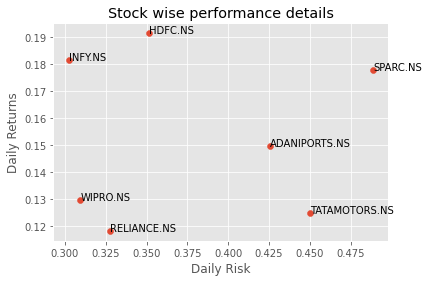

In [ ]:
plt.scatter(StockMetrics['Annualized Risk'],StockMetrics['Annualized Returns'])
for i in range(StockMetrics.shape[0]):
    plt.text(StockMetrics['Annualized Risk'][i],StockMetrics['Annualized Returns'][i],StockMetrics.index[i])
plt.xlabel('Daily Risk')
plt.ylabel('Daily Returns')
plt.title('Stock wise performance details')
plt.show()

In [ ]:
corr = dailyrets.corr()
corr.style.background_gradient()

,ADANIPORTS.NS,HDFC.NS,INFY.NS,RELIANCE.NS,SPARC.NS,TATAMOTORS.NS,WIPRO.NS
ADANIPORTS.NS,1.000000,0.306887,0.222274,0.354895,0.247210,0.317986,0.223694
HDFC.NS,0.306887,1.000000,0.316578,0.425708,0.217898,0.368192,0.321720
INFY.NS,0.222274,0.316578,1.000000,0.331897,0.147585,0.274255,0.565657
RELIANCE.NS,0.354895,0.425708,0.331897,1.000000,0.251662,0.424562,0.354188
SPARC.NS,0.247210,0.217898,0.147585,0.251662,1.000000,0.274800,0.193176
TATAMOTORS.NS,0.317986,0.368192,0.274255,0.424562,0.274800,1.000000,0.323073
WIPRO.NS,0.223694,0.321720,0.565657,0.354188,0.193176,0.323073,1.000000


# 5) Optimization with initial params

In [ ]:
# Building the portfolio object
port = pf.Portfolio(returns=x_train)

# Calculating optimal portfolio
# Select method and estimate input parameters:
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:
model='Classic' # Could be Classic(historical), BL(Black Litterman), FM(Factor Model) or BL_FM(Black litterman with factors)
rm = 'MV' # Risk measure used, there are 13 available risk measures
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
w.T

,ADANIPORTS.NS,HDFC.NS,INFY.NS,RELIANCE.NS,SPARC.NS,TATAMOTORS.NS,WIPRO.NS
weights,0.086333,0.302048,0.4727,2.945044e-08,0.138918,7.431999e-09,9.658717e-08


# 6) Analyzing the results

## Stock wise allocation

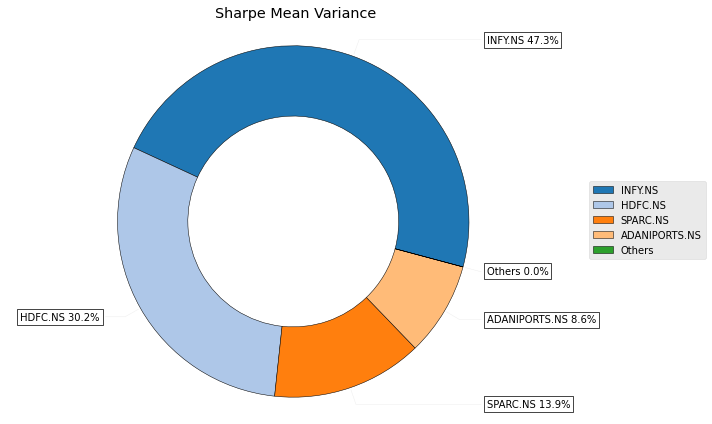

In [ ]:
# Plotting the composition of the portfolio
ax = plf.plot_pie(w=w, title='Sharpe Mean Variance',  height=6, width=10)

## Stock wise risk contribution

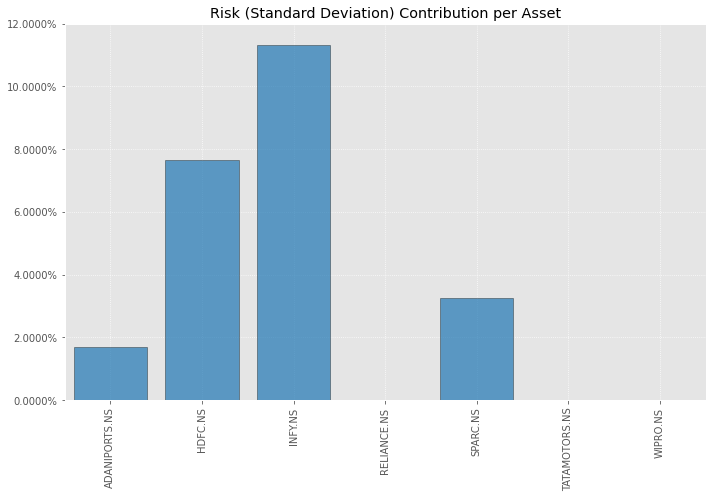

In [ ]:
cov = port.cov
ax = pf.plot_risk_con(w=w, cov=cov, returns=x_train, rm=rm,
                      rf=0, alpha=0.05, color="tab:blue", height=6,
                      width=10, t_factor=252, ax=None)
plt.xticks(rotation = 90)
plt.show()

## Historic portfolio performance

/usr/local/lib/python3.7/dist-packages/riskfolio/RiskFunctions.py:356: RuntimeWarning: overflow encountered in exp
  value = np.mean(np.exp(-1 / z * a), axis=0)


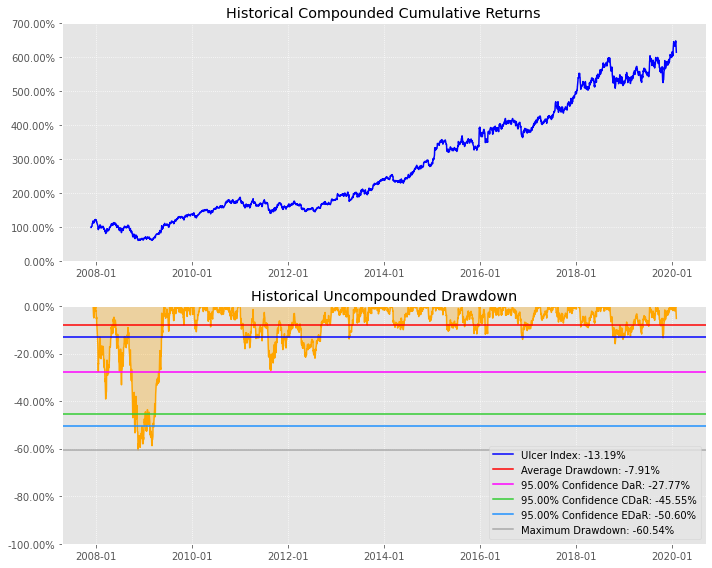

In [ ]:
nav=port.nav
ax = pf.plot_drawdown(nav=nav, w=w, alpha=0.05, height=8, width=10, ax=None)

## Test performance

### Test Equity curve

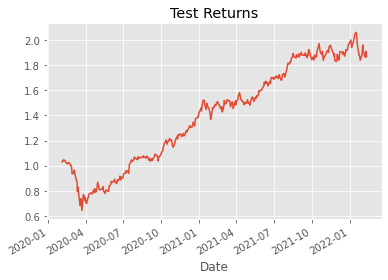

In [ ]:
test_eq_curve = (x_test.add(1).cumprod()*w['weights']).sum(axis=1)
test_eq_curve.plot()
plt.title('Test Returns')
plt.show()

In [ ]:
test_rets = test_eq_curve.pct_change()

### Benchmark returns

In [ ]:
benchmark_prices = yf.download('^NSEI',progress=False)
benchmark_rets = benchmark_prices['Adj Close'].pct_change()
compare_rets = pd.concat([test_rets,benchmark_rets],axis=1)
start_date = max(benchmark_rets.index.min(),test_rets.index.min())
compare_rets = compare_rets.loc[start_date:].fillna(0).dropna()
compare_rets.columns = ['test_rets','benchmark_rets']
compare_rets = compare_rets.dropna()
compare_rets.head()

,test_rets,benchmark_rets
Date,,
2020-02-04,0.000000,0.023211
2020-02-05,0.007711,0.009141
2020-02-06,-0.000834,0.004037
2020-02-07,0.010604,-0.003263
2020-02-10,-0.006348,-0.005526


### Pyfolio analysis

Start date,2020-02-04
End date,2022-02-11
Total months,24
,Backtest
Annual return,34.603%
Cumulative returns,81.179%
Annual volatility,28.223%
Sharpe ratio,1.20
Calmar ratio,0.90
Stability,0.92
Max drawdown,-38.426%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.43,2020-02-07,2020-03-23,2020-07-27,122
1,10.70,2022-01-17,2022-01-27,NaT,NaN
2,10.00,2021-01-11,2021-01-29,2021-03-10,43
3,7.26,2021-10-19,2021-11-29,2021-12-31,54
4,6.30,2021-04-09,2021-05-04,2021-05-26,34


Stress Events,mean,min,max
New Normal,0.13%,-12.55%,7.44%


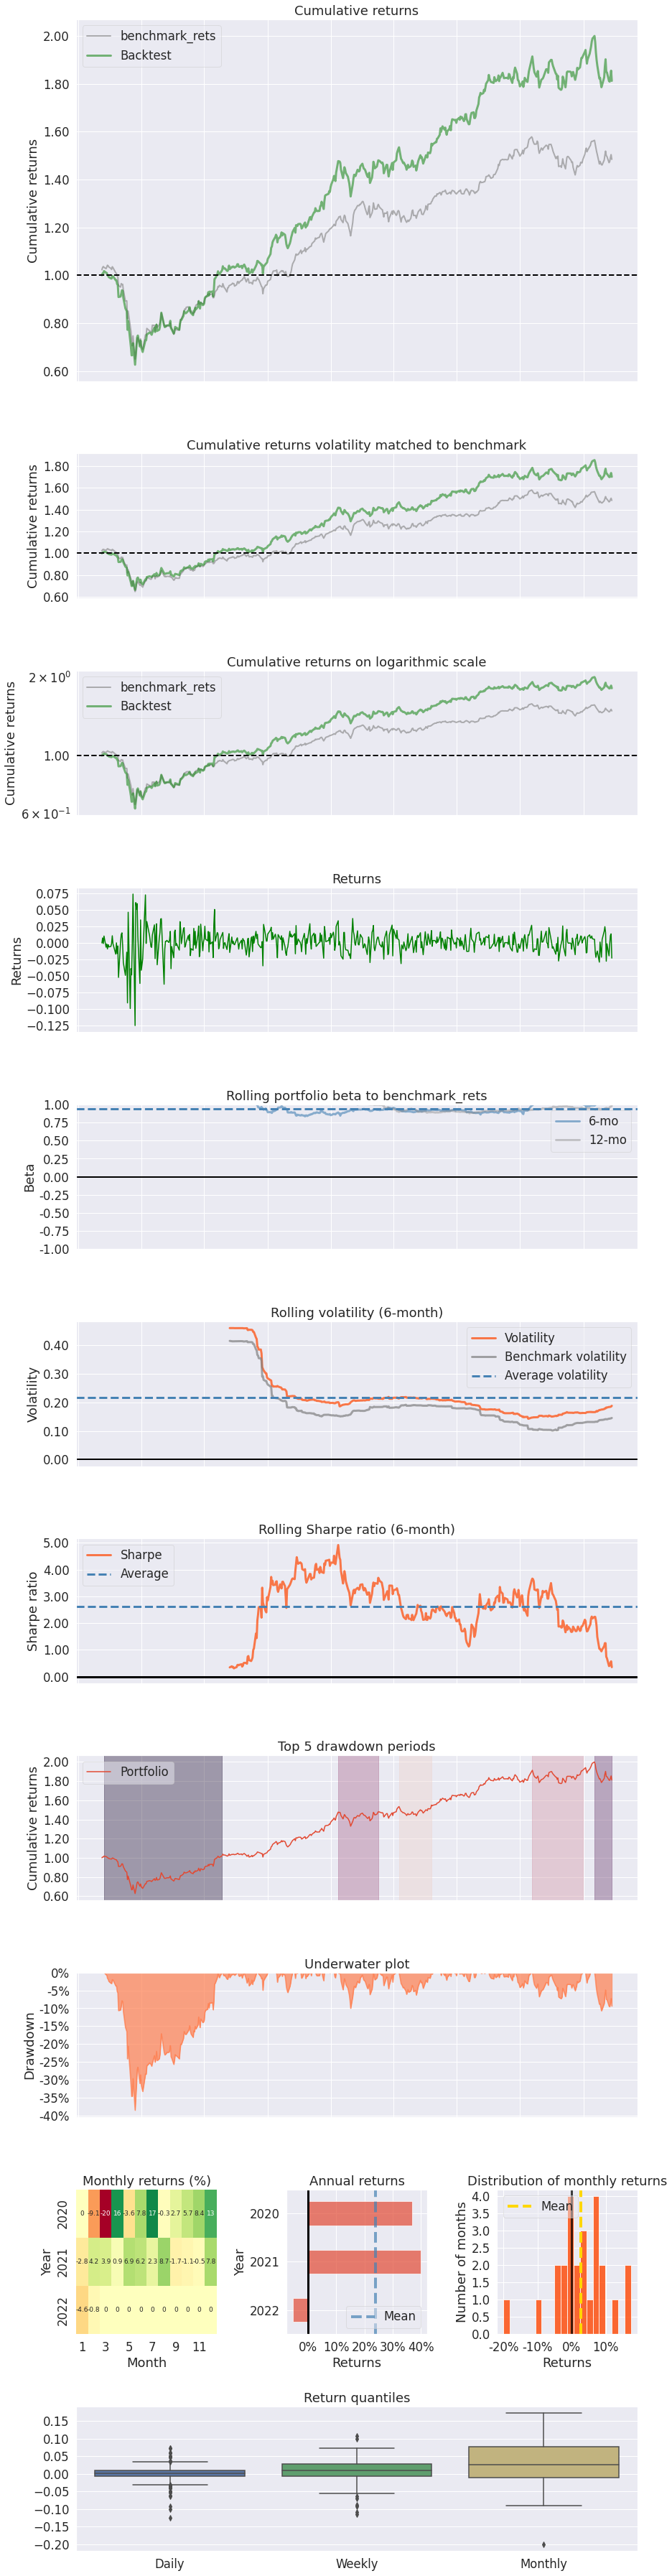

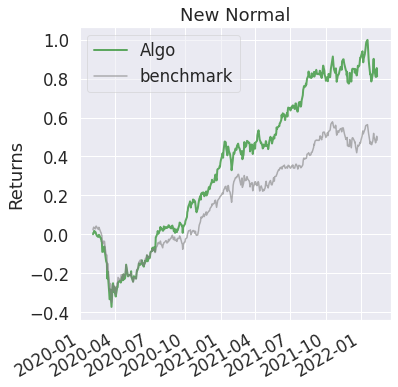

In [ ]:
pyf.create_full_tear_sheet(returns=compare_rets['test_rets'],benchmark_rets=compare_rets['benchmark_rets'])

# 7) Optimization for a different params

## Run Optimization

In [ ]:
# Estimate optimal portfolio:
model='Classic' # Could be Classic(historical), BL(Black Litterman), FM(Factor Model) or BL_FM(Black litterman with factors)
rm = 'CVaR' # Risk measure used, there are 13 available risk measures
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
w.T

,ADANIPORTS.NS,HDFC.NS,INFY.NS,RELIANCE.NS,SPARC.NS,TATAMOTORS.NS,WIPRO.NS
weights,0.032098,0.39354,0.381581,4.959204e-13,0.192781,1.598182e-13,4.935463e-13


## Stock wise allocation

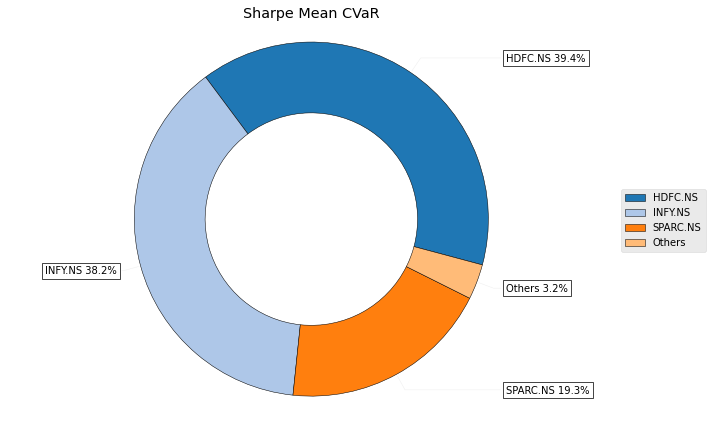

In [ ]:
# Plotting the composition of the portfolio
ax = plf.plot_pie(w=w, title='Sharpe Mean CVaR',  height=6, width=10)

## Stock wise risk contribution

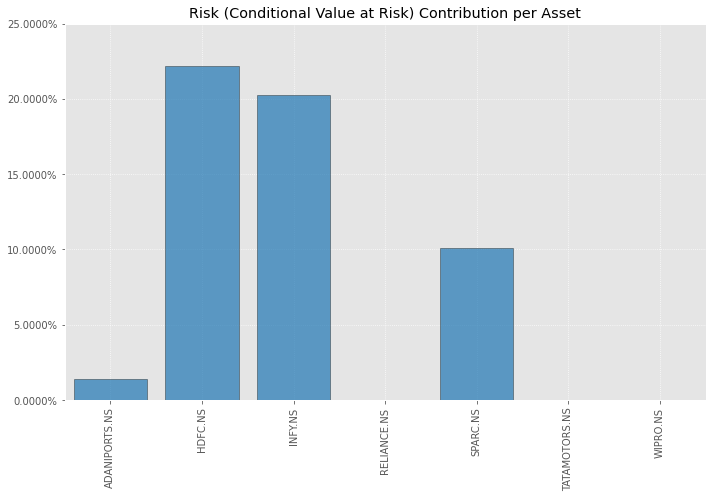

In [ ]:
cov = port.cov
ax = pf.plot_risk_con(w=w, cov=cov, returns=x_train, rm=rm,
                      rf=0, alpha=0.05, color="tab:blue", height=6,
                      width=10, t_factor=252, ax=None)
plt.xticks(rotation = 90)
plt.show()

# 8) All parameter weights

## Parameter Grid

**Different Risk Measures**

*   Standard Deviation
*   Mean Absolute Deviation
*   Semi Standard Deviation
*   First Lower Partial Moment (Omega Ratio)
*   Conditional Value at Risk
*   Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio)
*   Average Drawdown of uncompounded cumulative returns
*   Ulcer Index of uncompounded cumulative returns

In [ ]:
rms = ['MV', 'MAD', 'MSV', 'FLPM', 'CVaR','MDD', 'ADD', 'UCI']
obj_funcs = ['MinRisk', 'Sharpe', 'MaxRet']

## Allocation weights

In [ ]:
all_wts = pd.DataFrame()
for rm,obj in itertools.product(rms,obj_funcs):
  print('working on:',rm,obj)
  w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
  w.columns = [obj+'_'+rm]
  all_wts = pd.concat([all_wts,w],axis=1)

working on: MV MinRisk
working on: MV Sharpe
working on: MV MaxRet
working on: MAD MinRisk
working on: MAD Sharpe
working on: MAD MaxRet
working on: MSV MinRisk
working on: MSV Sharpe
working on: MSV MaxRet
working on: FLPM MinRisk
working on: FLPM Sharpe
working on: FLPM MaxRet
working on: CVaR MinRisk
working on: CVaR Sharpe
working on: CVaR MaxRet
working on: MDD MinRisk
working on: MDD Sharpe
working on: MDD MaxRet
working on: ADD MinRisk
working on: ADD Sharpe
working on: ADD MaxRet
working on: UCI MinRisk
working on: UCI Sharpe
working on: UCI MaxRet


In [ ]:
all_wts

,MinRisk_MV,Sharpe_MV,MaxRet_MV,MinRisk_MAD,Sharpe_MAD,MaxRet_MAD,MinRisk_MSV,Sharpe_MSV,MaxRet_MSV,MinRisk_FLPM,Sharpe_FLPM,MaxRet_FLPM,MinRisk_CVaR,Sharpe_CVaR,MaxRet_CVaR,MinRisk_MDD,Sharpe_MDD,MaxRet_MDD,MinRisk_ADD,Sharpe_ADD,MaxRet_ADD,MinRisk_UCI,Sharpe_UCI,MaxRet_UCI
ADANIPORTS.NS,0.098700,8.633259e-02,5.325814e-10,0.079037,5.759173e-02,1.191779e-11,8.297957e-02,5.592117e-02,1.191779e-11,7.249335e-02,5.564473e-02,1.191942e-11,9.688544e-02,3.209760e-02,1.191783e-11,2.343647e-13,2.440193e-14,3.785885e-12,1.535564e-09,1.408086e-14,5.279493e-12,1.333087e-10,5.555724e-11,5.279493e-12
HDFC.NS,0.149132,3.020484e-01,1.000000e+00,0.249438,3.949858e-01,1.000000e+00,2.269887e-01,4.072138e-01,1.000000e+00,2.624663e-01,3.988119e-01,1.000000e+00,1.831470e-01,3.935404e-01,1.000000e+00,3.572870e-01,3.572870e-01,1.000000e+00,6.400578e-01,7.110698e-01,1.000000e+00,5.924253e-01,6.190570e-01,1.000000e+00
INFY.NS,0.283718,4.727005e-01,2.758948e-08,0.265825,4.234170e-01,2.479114e-10,2.639478e-01,4.150323e-01,2.479114e-10,2.696853e-01,4.147425e-01,2.478257e-10,2.030003e-01,3.815813e-01,2.479122e-10,6.427130e-01,6.427130e-01,2.187688e-11,2.874685e-01,2.889302e-01,2.977674e-11,4.075747e-01,3.809430e-01,2.977674e-11
RELIANCE.NS,0.170407,2.945044e-08,5.155512e-10,0.172937,1.626749e-02,9.443699e-12,1.608954e-01,2.086994e-11,9.443699e-12,1.647494e-01,1.678978e-02,9.443231e-12,1.655722e-01,4.959204e-13,9.443731e-12,4.800263e-12,2.668722e-14,2.073190e-12,6.073569e-02,1.726914e-14,2.927056e-12,2.836944e-10,6.522162e-11,2.927056e-12
SPARC.NS,0.097484,1.389184e-01,6.901641e-09,0.053186,7.724034e-02,4.800621e-11,8.060780e-02,1.218327e-01,4.800621e-11,6.093341e-02,7.946124e-02,4.796666e-11,1.305980e-01,1.927807e-01,4.800636e-11,1.753115e-13,1.890605e-14,1.439394e-11,2.286456e-11,2.310255e-14,1.972022e-11,8.886305e-11,3.687633e-11,1.972022e-11
TATAMOTORS.NS,0.008595,7.431999e-09,5.304283e-10,0.002611,1.160036e-14,9.829641e-12,1.161148e-07,4.328102e-12,9.829641e-12,6.355564e-12,3.417836e-15,9.829480e-12,1.557673e-11,1.598182e-13,9.829674e-12,2.277417e-13,2.244221e-14,2.302069e-12,4.685795e-12,4.333967e-14,3.223824e-12,1.019352e-10,5.709431e-11,3.223824e-12
WIPRO.NS,0.191965,9.658717e-08,5.399747e-10,0.176965,3.049767e-02,1.018278e-11,1.845806e-01,4.191308e-11,1.018278e-11,1.696722e-01,3.454993e-02,1.018288e-11,2.207970e-01,4.935463e-13,1.018281e-11,2.341268e-13,2.522871e-14,2.488564e-12,1.173796e-02,1.416827e-14,3.493303e-12,7.289411e-11,5.966901e-11,3.493303e-12


## Test Equity curves

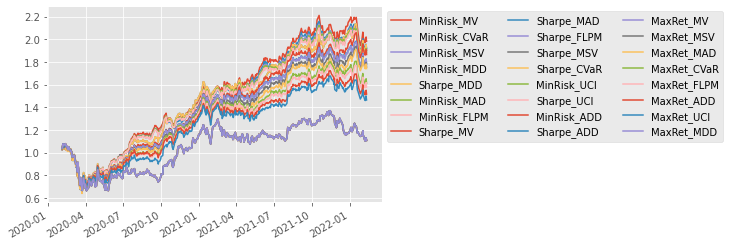

In [ ]:
all_equity_curves = pd.DataFrame()
all_perf_vals = pd.DataFrame()
for col in all_wts.columns:
  test_eq_curve = (x_test.add(1).cumprod()*all_wts[col]).sum(axis=1)
  test_eq_curve.name = col
  test_perv_vals = pyf.timeseries.perf_stats(test_eq_curve.pct_change())
  test_perv_vals.name = col
  all_equity_curves = pd.concat([all_equity_curves,test_eq_curve],axis=1)
  all_perf_vals = pd.concat([all_perf_vals,test_perv_vals],axis=1)
sorted_by_perf_cols = all_equity_curves.pct_change().add(1).cumprod().iloc[-1].sort_values(ascending=False).index
all_equity_curves = all_equity_curves[sorted_by_perf_cols]
all_equity_curves.plot()
plt.legend(bbox_to_anchor = (1,1),ncol=3)
plt.show()

## Test Performance numbers

In [ ]:
all_perf_vals = all_perf_vals.T
all_perf_vals = all_perf_vals.sort_values('Annual return',ascending=False)
all_perf_vals = all_perf_vals[['Annual return','Sharpe ratio','Max drawdown']]
all_perf_vals

,Annual return,Sharpe ratio,Max drawdown
MinRisk_MV,0.390674,1.379953,-0.376337
MinRisk_CVaR,0.368705,1.315752,-0.383169
MinRisk_MSV,0.360698,1.295986,-0.370488
MinRisk_MDD,0.358373,1.185732,-0.348775
Sharpe_MDD,0.358373,1.185732,-0.348775
MinRisk_MAD,0.354360,1.275743,-0.367815
MinRisk_FLPM,0.348610,1.258549,-0.367410
Sharpe_MV,0.346026,1.197616,-0.384264
Sharpe_MAD,0.316209,1.117808,-0.368858
Sharpe_FLPM,0.314179,1.112770,-0.369374


## Compare results with benchmark

Start date,2020-02-04
End date,2022-02-11
Total months,24
,Backtest
Annual return,39.067%
Cumulative returns,93.398%
Annual volatility,26.512%
Sharpe ratio,1.38
Calmar ratio,1.04
Stability,0.93
Max drawdown,-37.634%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,37.63,2020-02-07,2020-03-23,2020-07-15,114
1,12.08,2021-10-19,2022-01-27,NaT,NaN
2,8.47,2021-01-13,2021-01-29,2021-02-15,24
3,7.95,2020-10-13,2020-11-02,2020-12-02,37
4,6.24,2021-03-03,2021-03-25,2021-04-06,25


Stress Events,mean,min,max
New Normal,0.15%,-11.49%,8.20%


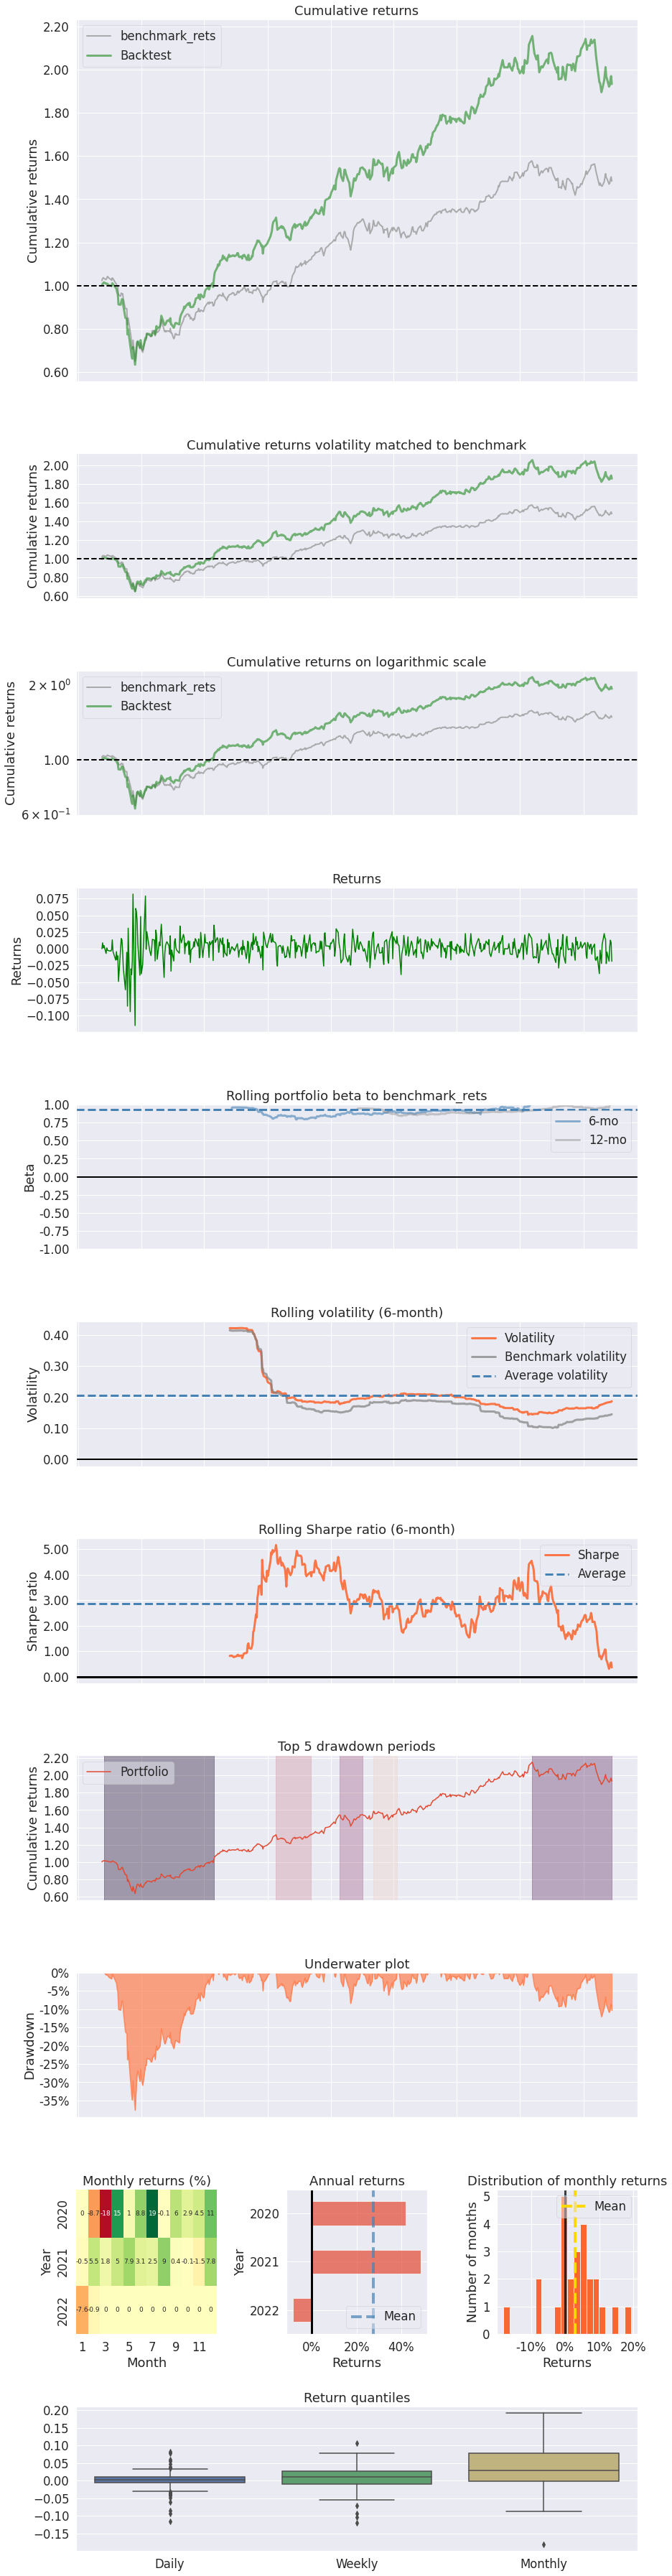

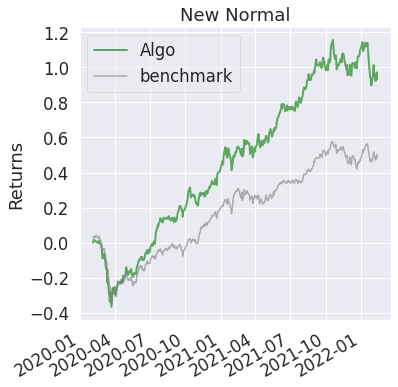

In [ ]:
comb_val = 'MinRisk_MV'
test_rets = all_equity_curves[comb_val].pct_change().copy()
compare_rets = pd.concat([test_rets,benchmark_rets],axis=1)
start_date = max(benchmark_rets.index.min(),test_rets.index.min())
compare_rets = compare_rets.loc[start_date:].fillna(0).dropna()
compare_rets.columns = ['test_rets','benchmark_rets']
compare_rets = compare_rets.dropna()
pyf.create_full_tear_sheet(returns=compare_rets['test_rets'],benchmark_rets=compare_rets['benchmark_rets'])